# Implementar

- Modelos clustering 
    - [ ] UFMG
    - [X] Kprototypes
    - [ ] Dinamic time warping
    - [ ] implemet different similarities functions
    
    
- Reducao de dimensionalidade
    - [X] PCA
    - [X] TSNE


- Search
    - [X] make search
    - [X] plot search results
    - [X] make TSNE different complexities on search results


Links:
    - http://deeplearning.csail.mit.edu/slide_cvpr2018/laurens_cvpr18tutorial.pdf
    - https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html

In [1]:
import pandas as pd
import sys

%load_ext autoreload
%autoreload 2
sys.path.insert(1, '../src/')

from guara.modeling.unsupervised_modelz import *
import utils

pd.set_option('display.max_columns', None)

# Import dataset

In [7]:
df = utils.import_s3_example_dataset('bombas')[['date',
                                                'vibracao_ponto_1',
                                                'vibracao_ponto_2',
                                                'vibracao_ponto_3',
                                                'vibracao_ponto_4',
                                                'vibracao_ponto_5'
                                               ]]
df.head()

date  vibracao_ponto_1  vibracao_ponto_2  vibracao_ponto_3  \
0 2017-12-28 15:00:00          1.150845          0.983295          2.066202   
1 2017-12-28 15:05:00          1.152106          0.980713          2.067280   
2 2017-12-28 15:10:00          1.216263          0.962285          2.037572   
3 2017-12-28 15:15:00          1.482624          0.761433          1.733252   
4 2017-12-28 15:20:00          1.482012          0.763680          1.734059   

   vibracao_ponto_4  vibracao_ponto_5  
0          4.444914          4.024140  
1          4.458808          4.021726  
2          4.539507          3.985949  
3          5.693767          3.722689  
4          5.697873          3.715978

# Train, Val

In [8]:
train_split = 0.8
n_train_split = int(train_split*len(df))

Xtrain = df.iloc[:n_train_split, :].copy()
Xval = df.iloc[n_train_split:, :].copy()

Xt_date = Xtrain.date.copy()
Xv_date = Xval.date.copy()

Xtrain = Xtrain.drop('date', axis = 1)
Xval = Xval.drop('date', axis = 1)

print(Xtrain.shape)
print(Xval.shape)
Xtrain.head()

(163900, 5)
(40976, 5)


vibracao_ponto_1  vibracao_ponto_2  vibracao_ponto_3  vibracao_ponto_4  \
0          1.150845          0.983295          2.066202          4.444914   
1          1.152106          0.980713          2.067280          4.458808   
2          1.216263          0.962285          2.037572          4.539507   
3          1.482624          0.761433          1.733252          5.693767   
4          1.482012          0.763680          1.734059          5.697873   

   vibracao_ponto_5  
0          4.024140  
1          4.021726  
2          3.985949  
3          3.722689  
4          3.715978


colunas numericas:
['vibracao_ponto_1', 'vibracao_ponto_2', 'vibracao_ponto_3', 'vibracao_ponto_4', 'vibracao_ponto_5']



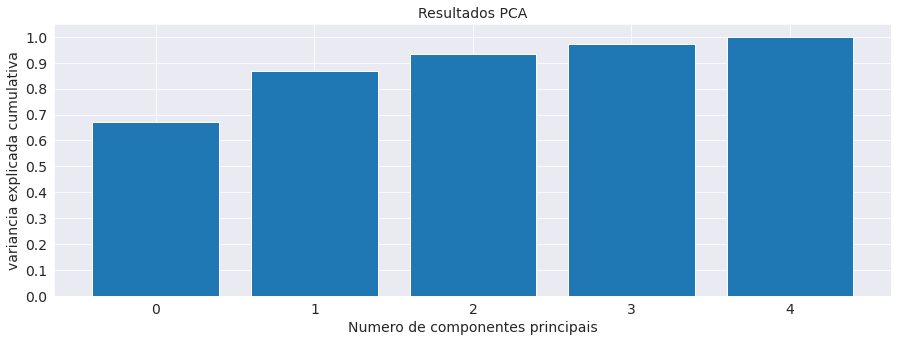

In [9]:
UnsupervisedModelz().plot_pca(Xtrain.sample(10_000))

escalonando os dados...


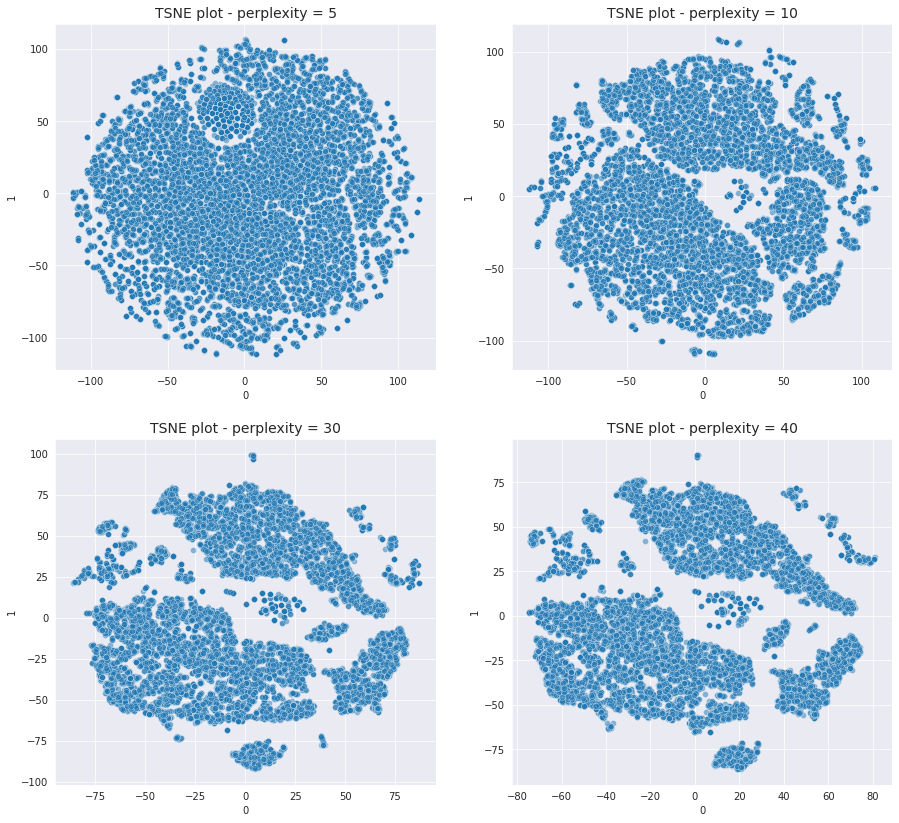

In [10]:
UnsupervisedModelz().plot_tsne(Xtrain.sample(frac = 0.1), alpha = 0.1)

# Isolation Forest

In [12]:
md = UnsupervisedModelz('isolation_forest')
Xtrain_p = md.preprocess_fit_transform(Xtrain)
Xtrain_p.head()

vibracao_ponto_1  vibracao_ponto_2  vibracao_ponto_3  vibracao_ponto_4  \
0          0.095807          0.147999          0.057597          0.243702   
1          0.095912          0.147611          0.057627          0.244464   
2          0.101253          0.144837          0.056798          0.248889   
3          0.123427          0.114606          0.048315          0.312174   
4          0.123376          0.114944          0.048338          0.312399   

   vibracao_ponto_5  
0          0.195596  
1          0.195479  
2          0.193740  
3          0.180944  
4          0.180618

In [13]:
params = {
    
     'bootstrap': False,
     'contamination': 'auto',
     'max_features': 1.0,
     'max_samples': 'auto',
     'n_estimators': 100,
     'n_jobs': -1,
     'random_state': 666,
     'verbose': 0,
     'warm_start': False
}

model, ti = md.fit(Xtrain_p, params, verbose = True)

Treinando o modelo ISOLATION_FOREST...
Modelo treinado em 0.02 minutos 



In [14]:
pred = md.predict(Xtrain_p)
pred

(array([0, 0, 0, ..., 0, 0, 0]),
 array([-0.4097094 , -0.41121497, -0.40843075, ..., -0.45363932,
        -0.45401006, -0.45326889]))

escalonando os dados...


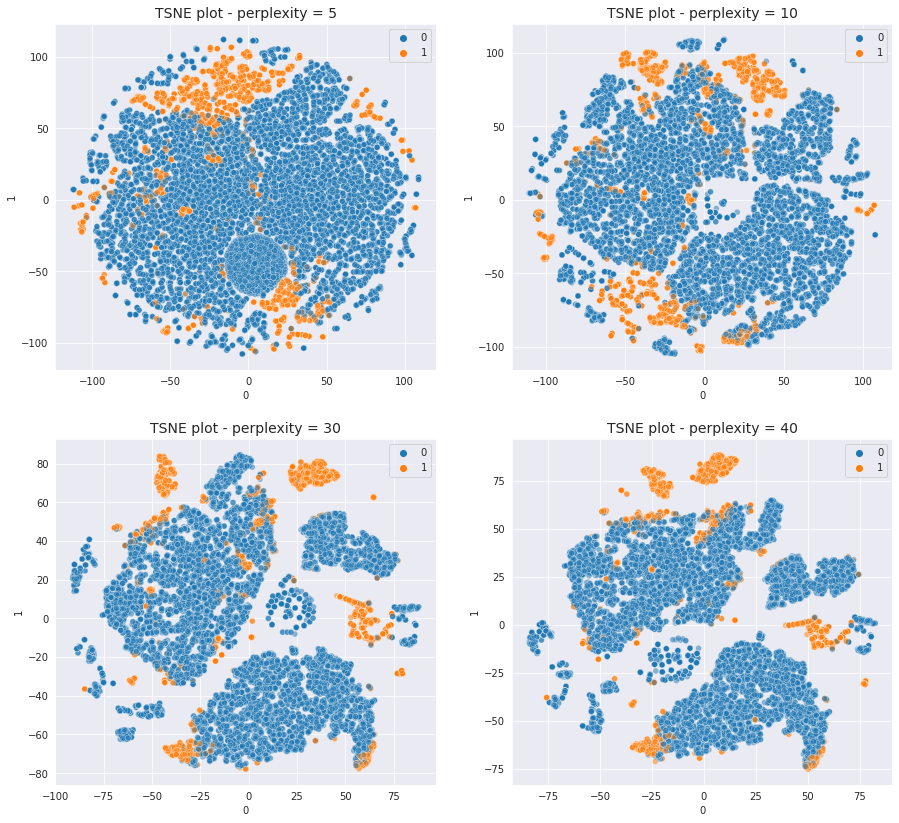

In [15]:
failure = pd.Series(pred[0].astype(str), index = Xtrain_p.index)
x = (Xtrain_p
     .sample(frac = 0.1)
     .copy()
     .assign(failure_= failure)
     .reset_index(drop = True)
    )

UnsupervisedModelz().plot_tsne(x.drop('failure_', axis = 1), pred = x['failure_'].tolist(), alpha = 0.1)

vibracao_ponto_1


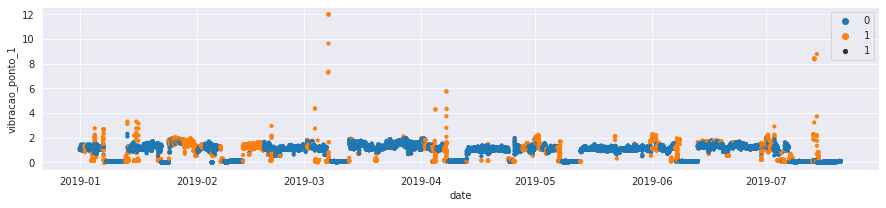

vibracao_ponto_2


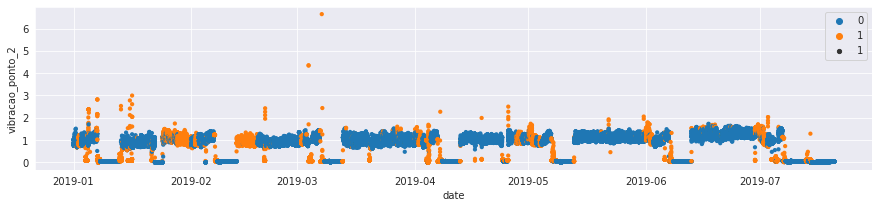

vibracao_ponto_3


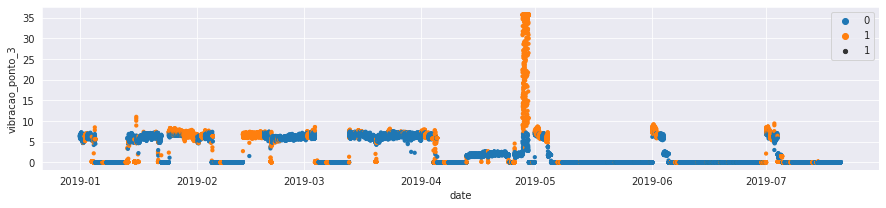

vibracao_ponto_4


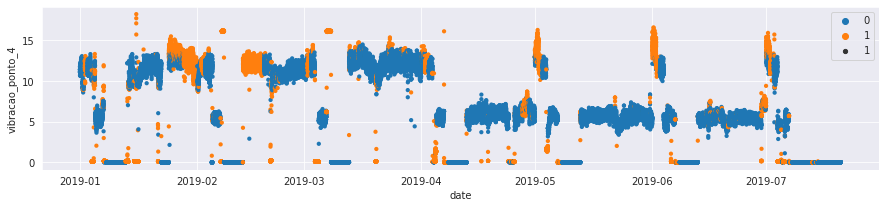

vibracao_ponto_5


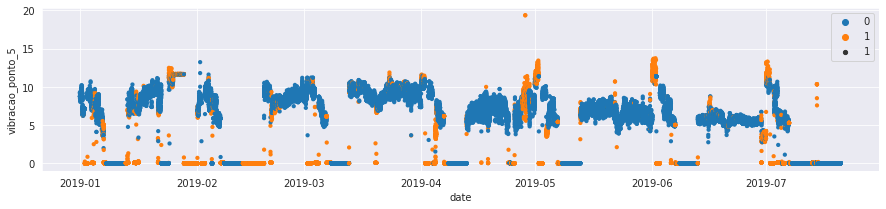

pred


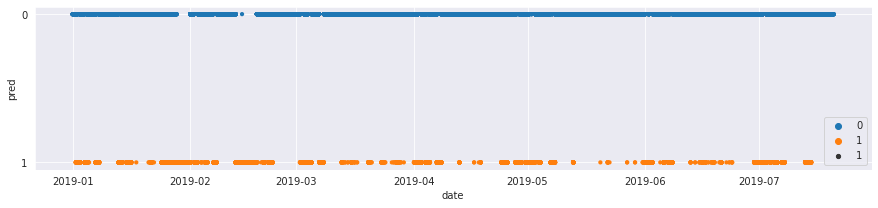

date


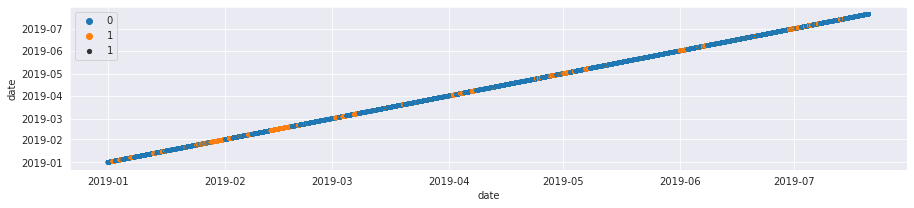

In [16]:
ts = (md
      .preprocess_inverse_transform(Xtrain_p)
      .assign(pred = pred[0].astype(str))
      .assign(date = Xt_date)
      .copy()
      .reset_index(drop = True)
     )

for i in ts.columns:
    print(i)
    plt.figure(figsize = (15,3))
    
    sns.scatterplot(
        
        data=ts[ts.date > '2019-01-01'],
        x ='date', 
        y=i,
        linewidth=0,
        size = 1,
        hue = ts[ts.date > '2019-01-01'].pred.tolist(),
        palette = 'tab10',
        
    )
    
    plt.show()

## Gausian Mixture

In [17]:
md = UnsupervisedModelz('gmm')
Xtrain_p = md.preprocess_fit_transform(Xtrain)

In [18]:
params = {
    'max_iter': 100, 
    'n_init': 3,
}

sr = md.search(Xtrain_p.sample(1000), params, min_clusters = 3, max_clusters = 15)

Realizando busca com o modelo GMM...
Fitted n_clusters = 3 (0.17 s)
Fitted n_clusters = 4 (0.25 s)
Fitted n_clusters = 5 (0.3 s)
Fitted n_clusters = 6 (0.34 s)
Fitted n_clusters = 7 (0.35 s)
Fitted n_clusters = 8 (0.43 s)
Fitted n_clusters = 9 (0.69 s)
Fitted n_clusters = 10 (0.72 s)
Fitted n_clusters = 11 (0.64 s)
Fitted n_clusters = 12 (0.76 s)
Fitted n_clusters = 13 (0.79 s)
Fitted n_clusters = 14 (0.71 s)
Fitted n_clusters = 15 (0.85 s)

Busca feita em 0.12 minutos


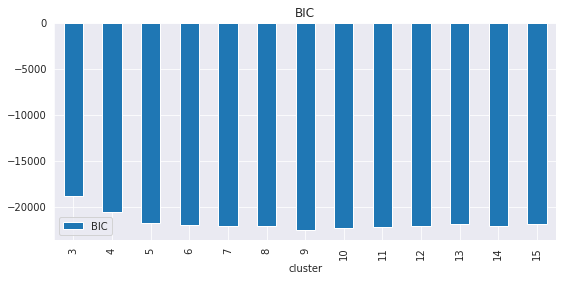

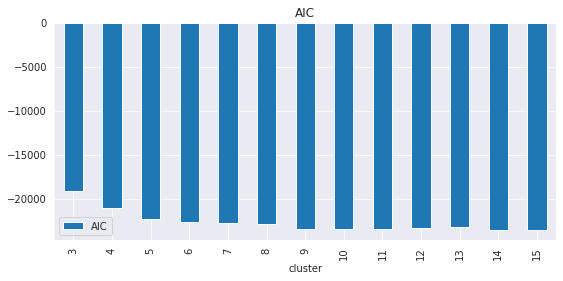

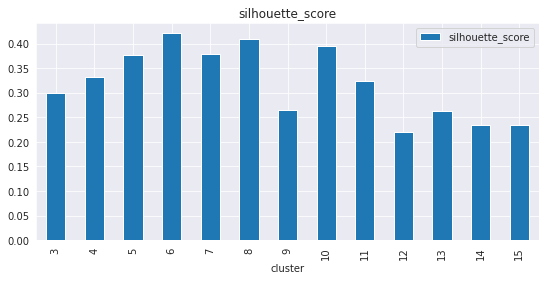

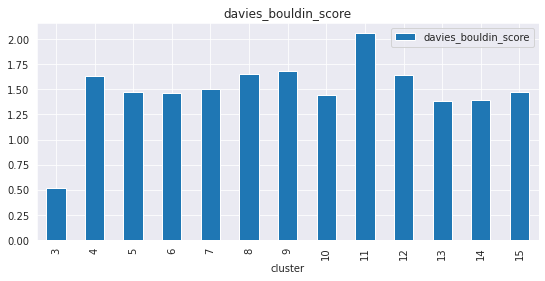

In [19]:
df_r = md.plot_search_results()

In [20]:
params = {
    'n_components':6, 
    'max_iter': 100, 
    'n_init': 1,
 
}

model, ti = md.fit(Xtrain_p.sample(20000), params, verbose = True)

Treinando o modelo GMM...
Modelo treinado em 0.45 minutos 



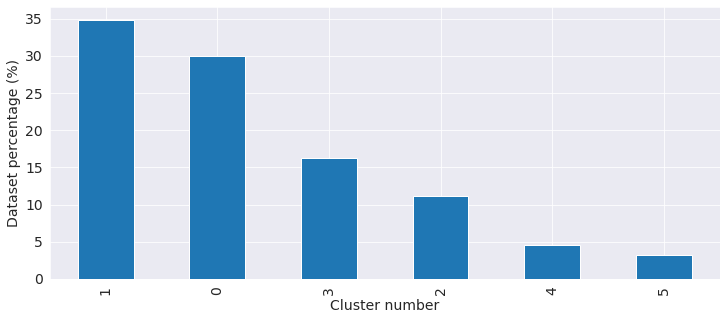

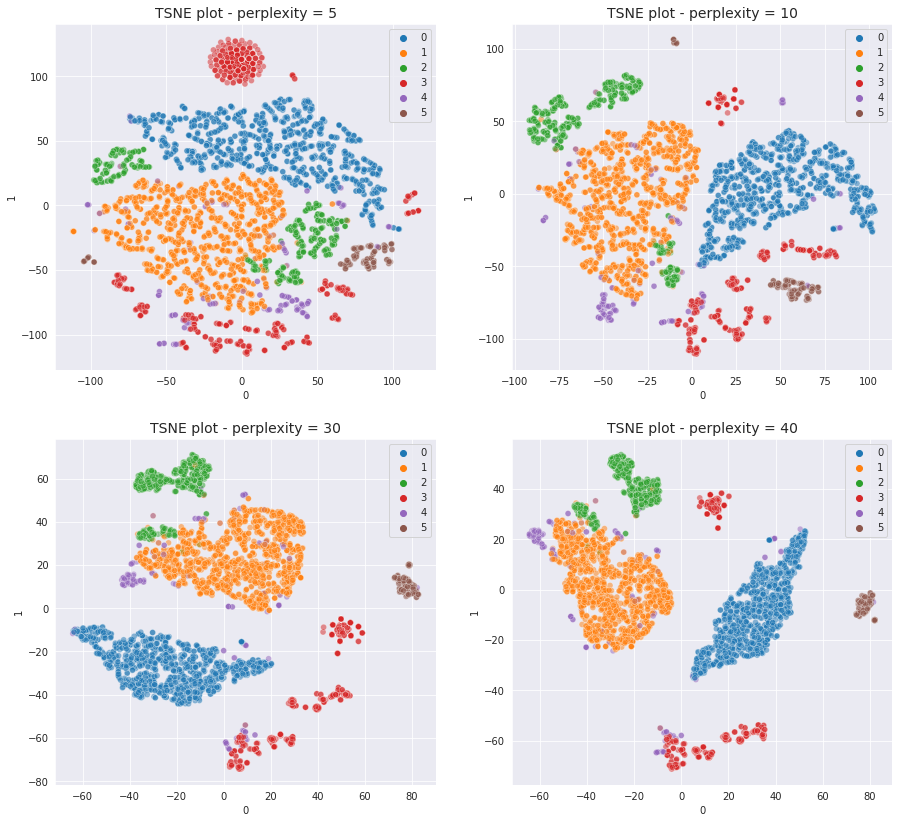


---- vibracao_ponto_1 -------------------------------------------------------


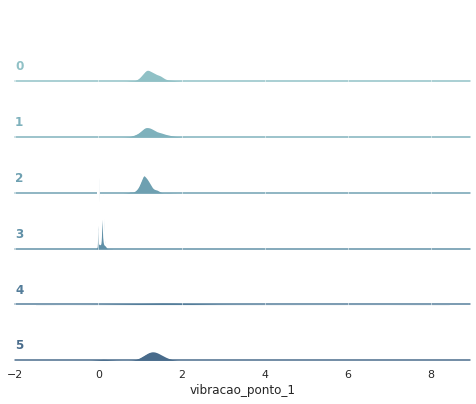


---- vibracao_ponto_2 -------------------------------------------------------


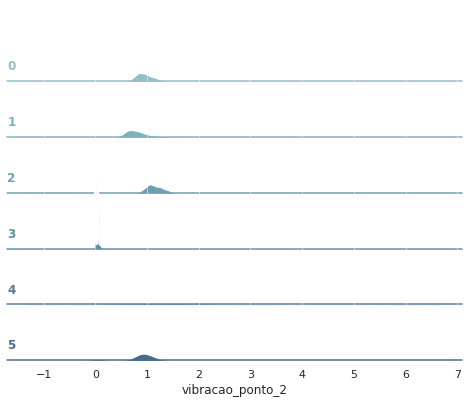


---- vibracao_ponto_3 -------------------------------------------------------


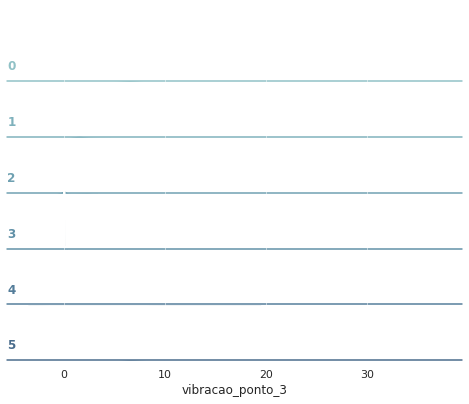


---- vibracao_ponto_4 -------------------------------------------------------


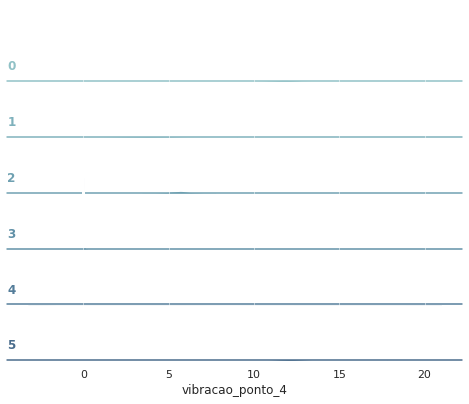


---- vibracao_ponto_5 -------------------------------------------------------


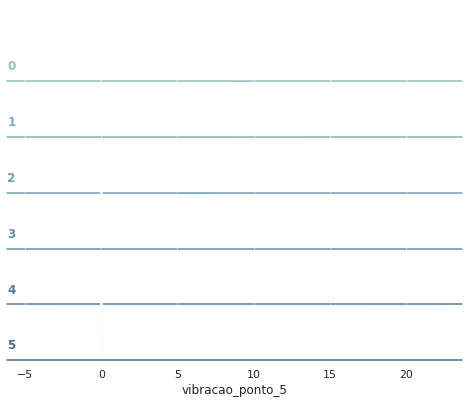

CENTROIDS:

|    |   vibracao_ponto_1 |   vibracao_ponto_2 |   vibracao_ponto_3 |   vibracao_ponto_4 |   vibracao_ponto_5 |
|----|--------------------|--------------------|--------------------|--------------------|--------------------|
|  0 |             1.2825 |             0.9535 |             6.5807 |            11.6630 |             9.1109 |
|  1 |             1.2835 |             0.8194 |             1.7295 |             3.6559 |             4.2145 |
|  2 |             1.1481 |             1.1554 |             0.4215 |             5.6603 |             6.5422 |
|  3 |             0.0576 |             0.0325 |             0.0111 |             0.0176 |             0.0151 |
|  4 |             2.2304 |             1.8132 |             3.8348 |             4.3558 |             6.3828 |
|  5 |             1.2031 |             0.8674 |             5.8835 |            12.4983 |             0.0089 |


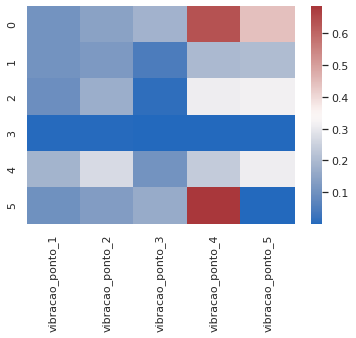

In [21]:
centroids = md.plot_train_info(Xtrain_p.sample(4_000))

In [27]:
pred

array([1, 1, 1, ..., 3, 3, 3])

vibracao_ponto_1


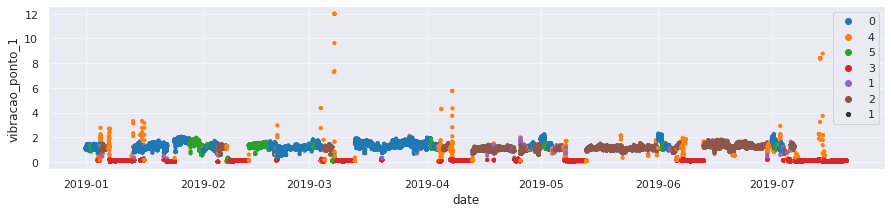

vibracao_ponto_2


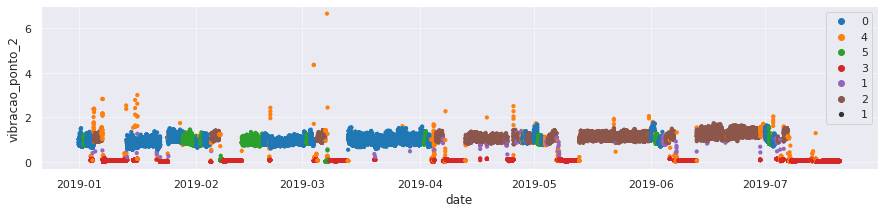

vibracao_ponto_3


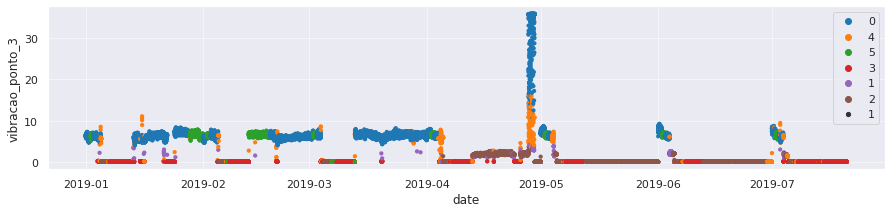

vibracao_ponto_4


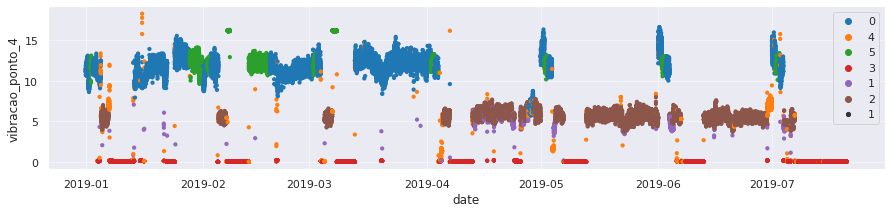

vibracao_ponto_5


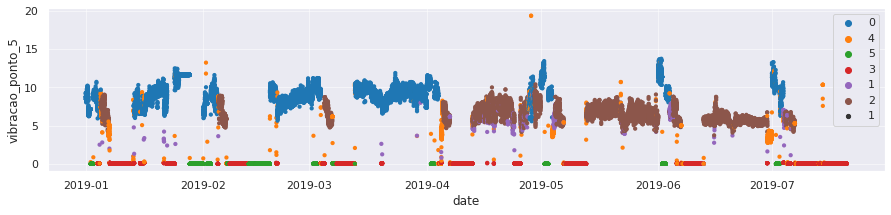

pred


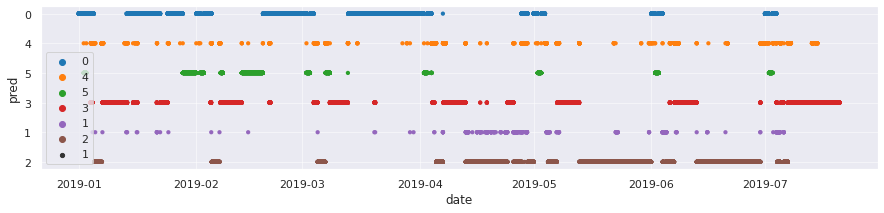

date


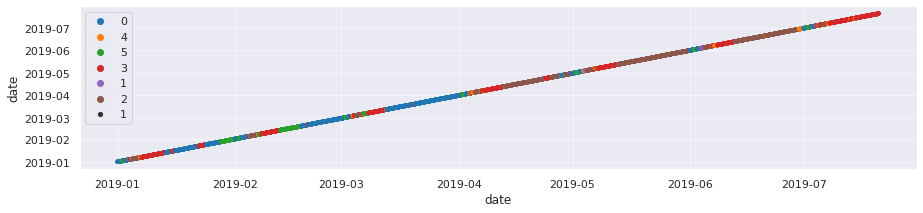

In [28]:
pred = md.predict(Xtrain_p)

ts = (md
      .preprocess_inverse_transform(Xtrain_p)
      .assign(pred = pred.astype(str))
      .assign(date = Xt_date)
      .copy()
      .reset_index(drop = True)
     )

for i in ts.columns:
    print(i)
    plt.figure(figsize = (15,3))
    
    sns.scatterplot(
        
        data=ts[ts.date > '2019-01-01'],
        x ='date', 
        y=i,
        linewidth=0,
        size = 1,
        hue = ts[ts.date > '2019-01-01'].pred.tolist(),
        palette = 'tab10',
        
    )
    
    plt.show()

# k-prototypes

In [29]:
df = utils.import_s3_example_dataset('marketing').drop('ID', axis = 1)

In [30]:
# transforma colunas object pra category
# FAZER ISSO NO PIPELINE
for col in df.columns:
    if is_string_dtype(df[col]):
        df[col] = df[col].astype('category')

train_split = 0.8
n_train_split = int(train_split*len(df))

Xtrain = df.iloc[:n_train_split, :].copy()
Xval = df.iloc[n_train_split:, :].copy()

print(Xtrain.shape)
print(Xval.shape)
Xtrain.head()

(1772, 35)
(444, 35)


Education Marital_Status     Income  Kidhome  Teenhome  Recency  MntWines  \
0  Graduation         Single  10.970592        0         0       58  6.455199   
1  Graduation         Single  10.743869        1         1       38  2.484907   
2  Graduation       Together  11.179046        0         0       26  6.056784   
3  Graduation       Together  10.190432        1         0       26  2.484907   
4         PhD        Married  10.973254        1         0       94  5.159055   

   MntFruits  MntMeatProducts  MntFishProducts  MntSweetProducts  \
0   4.488636         6.304449         5.153292          4.488636   
1   0.693147         1.945910         1.098612          0.693147   
2   3.912023         4.852030         4.718499          3.091042   
3   1.609438         3.044522         2.397895          1.386294   
4   3.784190         4.779123         3.850148          3.332205   

   MntGoldProds  NumDealsPurchases  NumWebPurchases  NumCatalogPurchases  \
0      4.488636           1.386294                8             2.397895   
1      1.945910           1.098612                1             0.693147   
2      3.761200           0.693147                8             1.098612   
3      1.791759           1.098612                2             0.000000   
4      2.772589           1.791759                5             1.386294   

   NumStorePurchases  NumWebVisitsMonth  Complain  Response  idade  \
0                  4                  7         0         1     63   
1                  2                  5         0         0     66   
2                 10                  4         0         0     55   
3                  4                  6         0         0     36   
4                  6                  5         0         0     39   

   dias_cliente  education_n  parceiro  pessoas_casa  renda_per_capta  \
0          2675            2         0             1        10.970592   
1          2125            2         0             3         9.645300   
2          2324            2         1             2        10.485913   
3          2151            2         1             3         9.091895   
4          2173            4         1             3         9.874676   

   compra_total_ano  porcentagem_compras_gold  gasto_renda  total_purchases  \
0             764.5                  0.055959     0.013064               22   
1              10.5                  0.251314     0.000227                4   
2             367.0                  0.055643     0.005112               20   
3              24.0                  0.099091     0.000900                6   
4             203.5                  0.036192     0.003485               14   

   disc_purchases  num_compras_ano  percent_disc_compra  ticket_medio  \
0        1.386294         3.001869             0.136364      5.543906   
1        1.098612         0.687059             0.500000      2.790093   
2        0.693147         3.141136             0.050000      4.769300   
3        1.098612         1.018131             0.333333      3.201632   
4        1.791759         2.351588             0.357143      4.472065   

   conversao_site  cupons_aceitados  
0        0.012736                 0  
1        0.002820                 0  
2        0.025490                 0  
3        0.004638                 0  
4        0.013711                 0

In [31]:
md = UnsupervisedModelz('kprototypes')

Xtrain_p = md.preprocess_fit_transform(Xtrain)
Xval_p = md.preprocess_transform(Xval)

Xtrain_p.head(2)

Education Marital_Status    Income  Kidhome  Teenhome   Recency  MntWines  \
0  Graduation         Single  0.773809      0.0       0.0  0.585859  0.883159   
1  Graduation         Single  0.723885      0.5       0.5  0.383838  0.339969   

   MntFruits  MntMeatProducts  MntFishProducts  MntSweetProducts  \
0   0.847181         0.830023         0.926737          0.847984   
1   0.130824         0.185309         0.197568          0.130948   

   MntGoldProds  NumDealsPurchases  NumWebPurchases  NumCatalogPurchases  \
0      0.805548           0.500000         0.727273             0.712113   
1      0.349220           0.396241         0.090909             0.205847   

   NumStorePurchases  NumWebVisitsMonth  Complain  Response     idade  \
0           0.307692               0.35       0.0       1.0  0.378641   
1           0.153846               0.25       0.0       0.0  0.407767   

   dias_cliente  education_n  parceiro  pessoas_casa  renda_per_capta  \
0      0.948498          0.5       0.0           0.0         0.814157   
1      0.161660          0.5       0.0           0.5         0.561190   

   compra_total_ano  porcentagem_compras_gold  gasto_renda  total_purchases  \
0          0.613189                  0.046169     0.043130           0.6875   
1          0.006836                  0.207347     0.000695           0.1250   

   disc_purchases  num_compras_ano  percent_disc_compra  ticket_medio  \
0        0.500000         0.560844             0.009091      0.857466   
1        0.396241         0.128364             0.033333      0.431539   

   conversao_site  cupons_aceitados  
0        0.153306               0.0  
1        0.033940               0.0

In [32]:
params = {
    #'n_clusters':3, 
    #'num_dissim': custom_distance,
    #'cat_dissim':
    'init': 'Cao', 
    'verbose': 0,
    'n_init':3,
    'n_jobs':4, 
    'max_iter': 200
}

sr = md.search(Xtrain_p, params, 2, 5)

Realizando busca com o modelo KPROTOTYPES...
Fitted n_clusters = 2 (4.93 s)
Fitted n_clusters = 3 (4.34 s)
Fitted n_clusters = 4 (4.49 s)
Fitted n_clusters = 5 (4.9 s)

Busca feita em 0.31 minutos


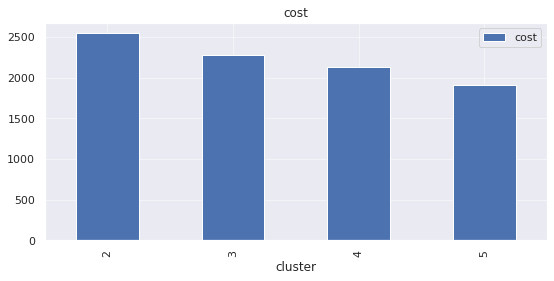

contagem de nulos muito alta (100.0%) na metrica silhouette_score!
contagem de nulos muito alta (100.0%) na metrica davies_bouldin_score!


In [34]:
df_r = md.plot_search_results()

In [35]:
md = UnsupervisedModelz('kprototypes')

Xtrain_p = md.preprocess_fit_transform(Xtrain)
Xval_p = md.preprocess_transform(Xval)


params = {
    'n_clusters':8, 
    'init': 'Cao', 
    'verbose': 2,
    'n_init':3,
    'n_jobs':4, 
    'max_iter': 200
}

md.cat_cols = ['Education', 'Marital_Status']
md.num_cols = Xtrain_p.columns.drop(md.cat_cols)

model, ti = md.fit(Xtrain_p, params, verbose = True)

Treinando o modelo KPROTOTYPES...
Best run was number 3
Modelo treinado em 0.11 minutos 



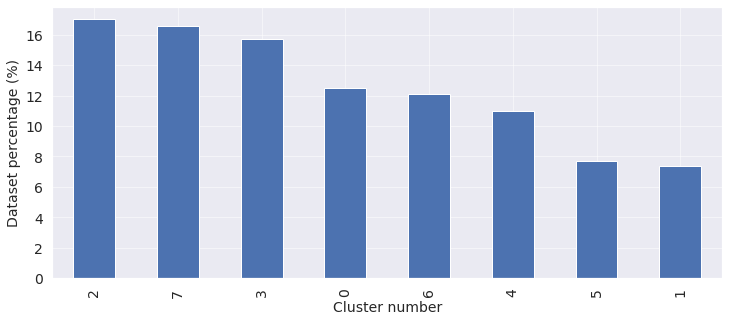

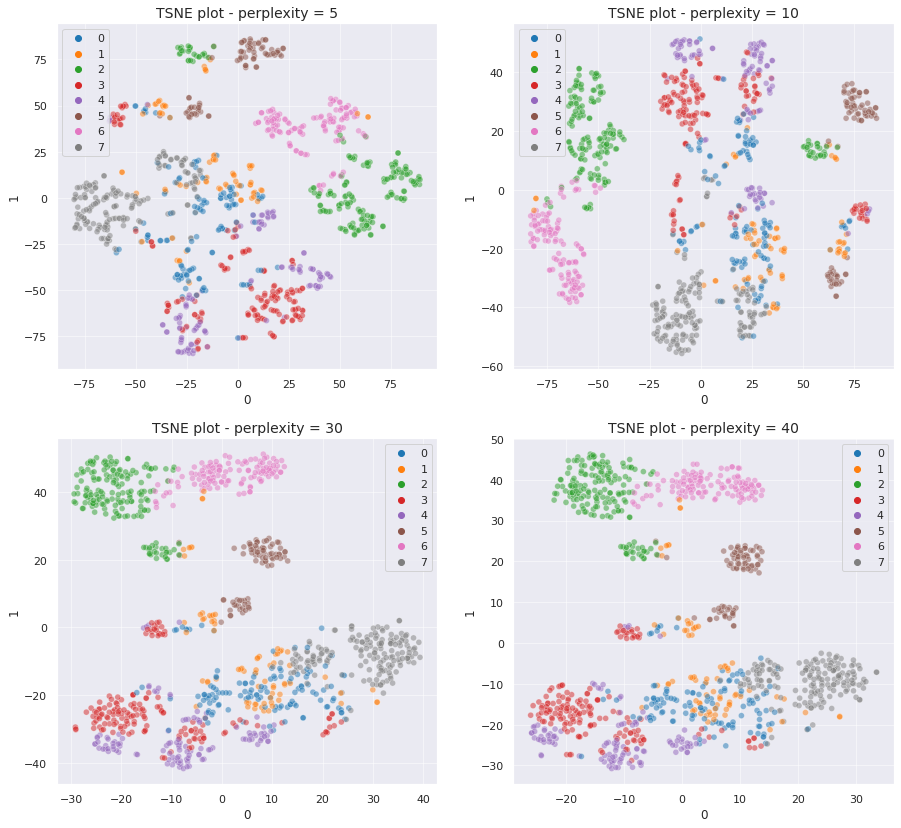

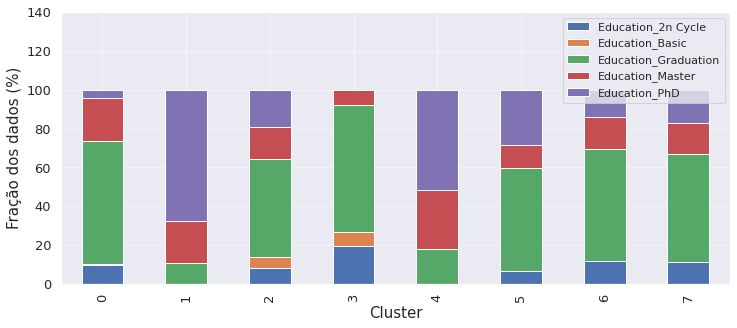

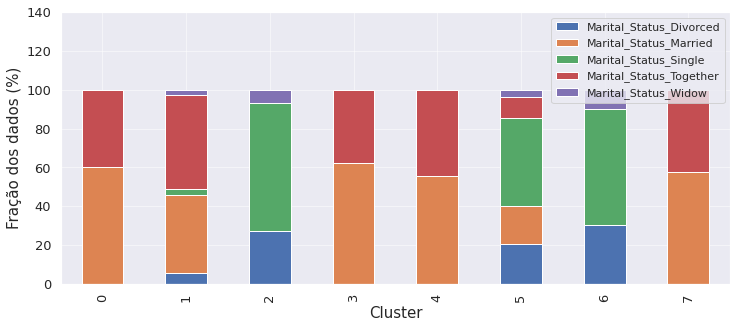


---- Income -------------------------------------------------------


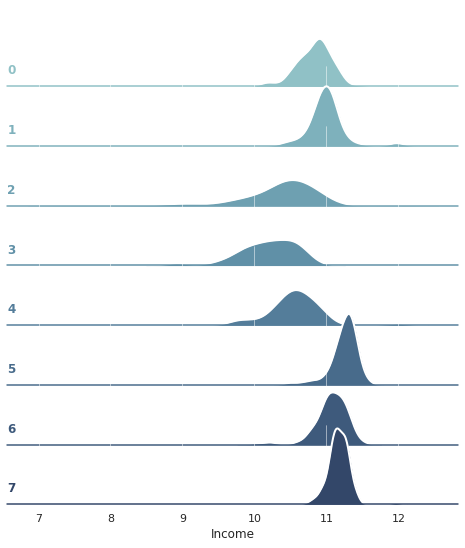


---- Kidhome -------------------------------------------------------


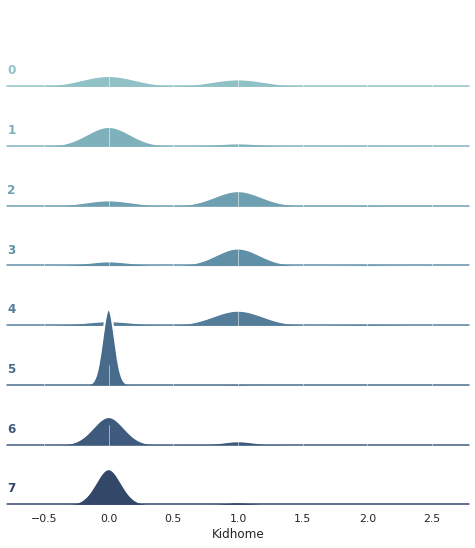


---- Teenhome -------------------------------------------------------


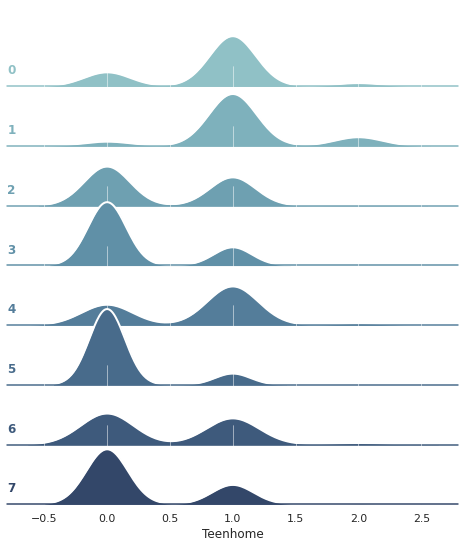


---- Recency -------------------------------------------------------


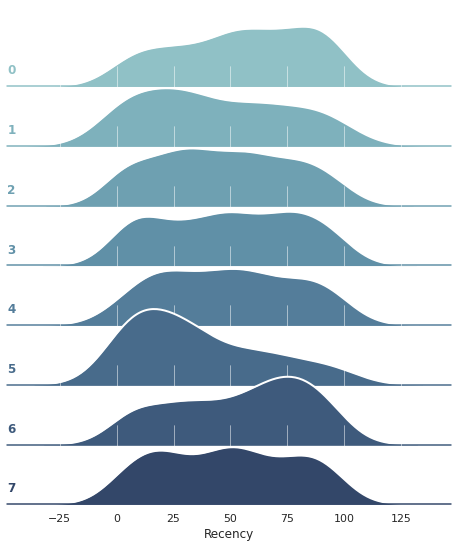


---- MntWines -------------------------------------------------------


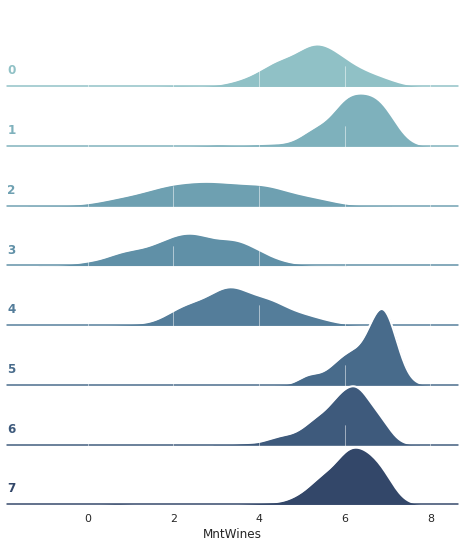


---- MntFruits -------------------------------------------------------


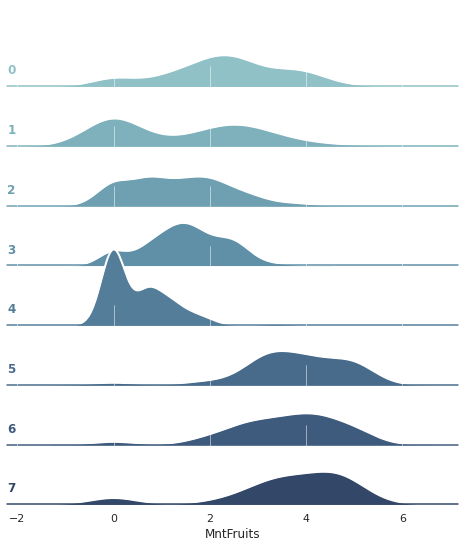


---- MntMeatProducts -------------------------------------------------------


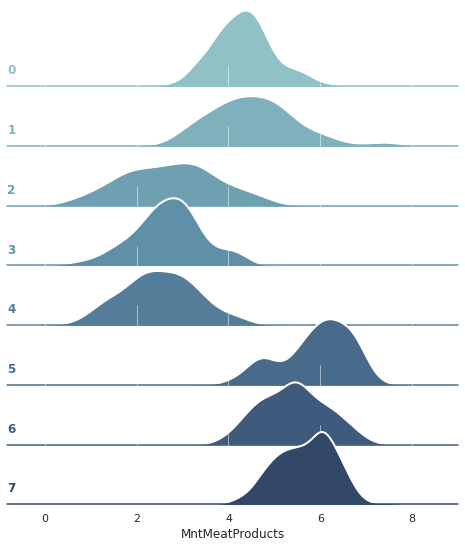


---- MntFishProducts -------------------------------------------------------


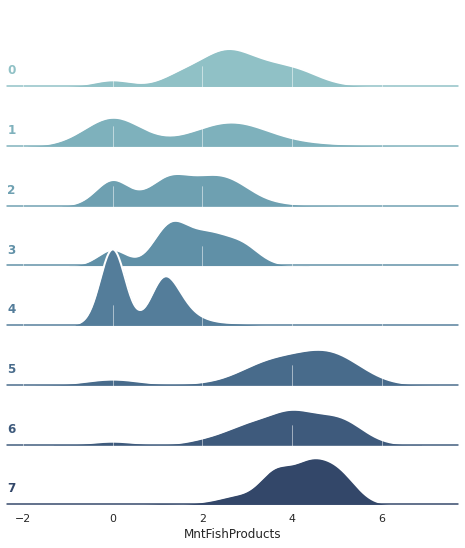


---- MntSweetProducts -------------------------------------------------------


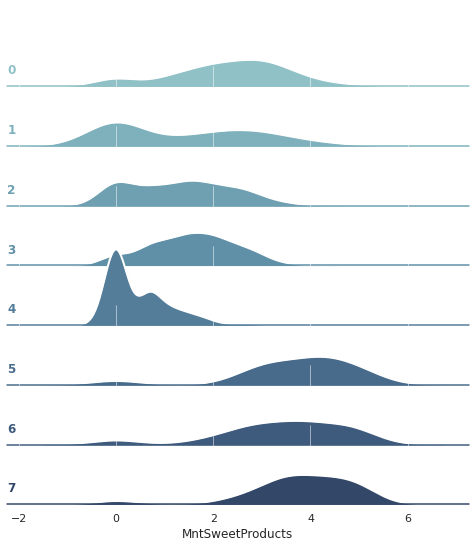


---- MntGoldProds -------------------------------------------------------


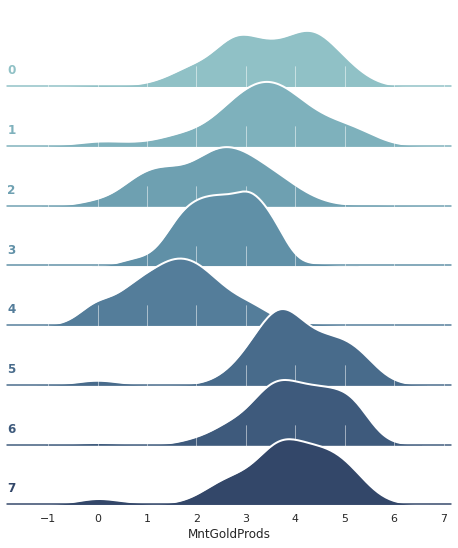


---- NumDealsPurchases -------------------------------------------------------


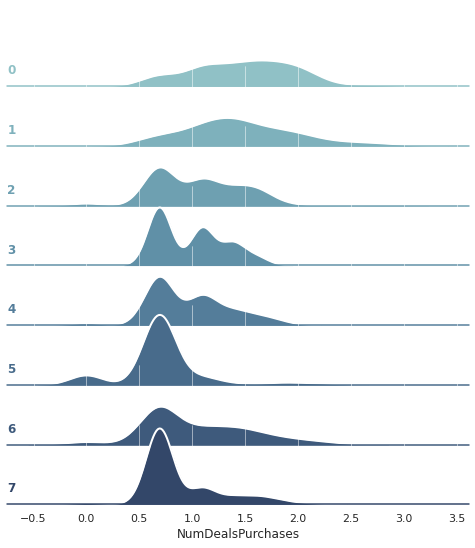


---- NumWebPurchases -------------------------------------------------------


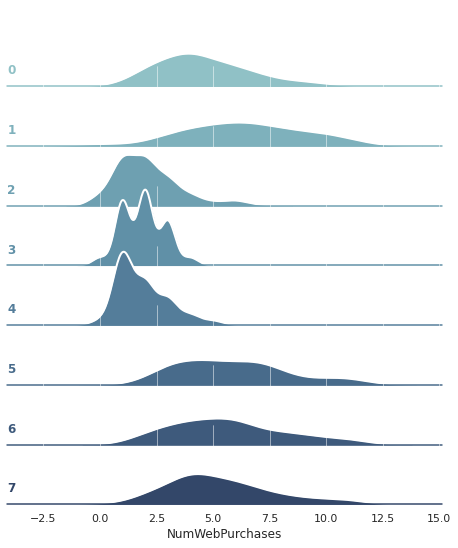


---- NumCatalogPurchases -------------------------------------------------------


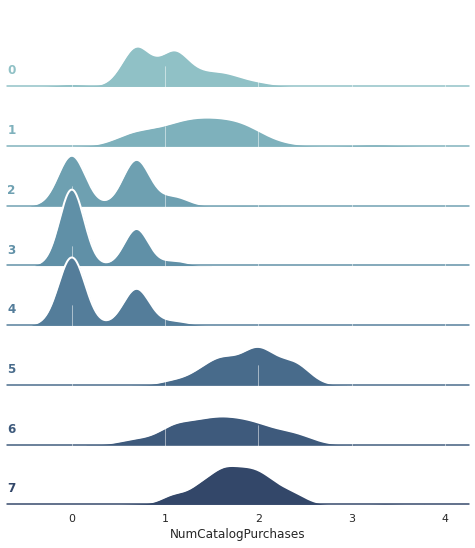


---- NumStorePurchases -------------------------------------------------------


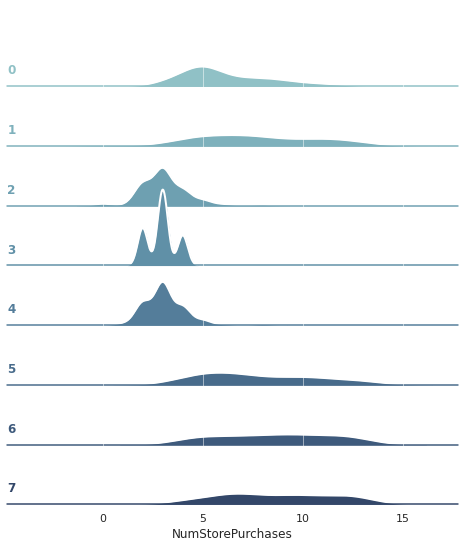


---- NumWebVisitsMonth -------------------------------------------------------


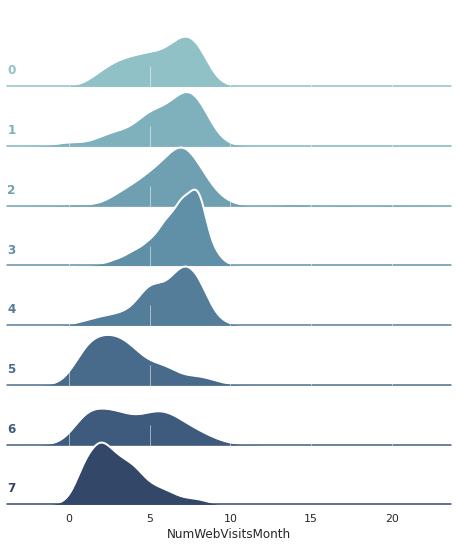


---- Complain -------------------------------------------------------


Dataset has 0 variance; skipping density estimate.
Dataset has 0 variance; skipping density estimate.
Dataset has 0 variance; skipping density estimate.
Dataset has 0 variance; skipping density estimate.
Dataset has 0 variance; skipping density estimate.
Dataset has 0 variance; skipping density estimate.


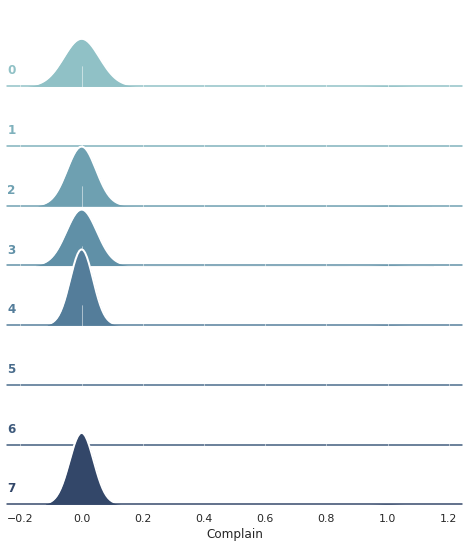


---- Response -------------------------------------------------------


Dataset has 0 variance; skipping density estimate.
Dataset has 0 variance; skipping density estimate.
Dataset has 0 variance; skipping density estimate.
Dataset has 0 variance; skipping density estimate.
Dataset has 0 variance; skipping density estimate.
Dataset has 0 variance; skipping density estimate.


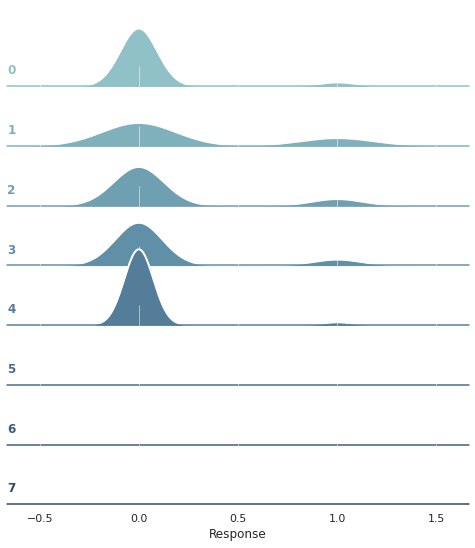


---- idade -------------------------------------------------------


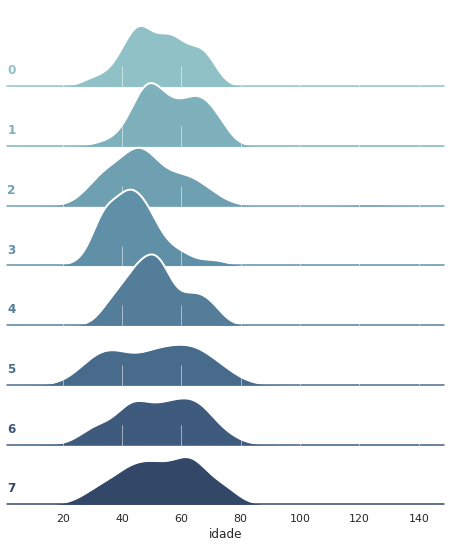


---- dias_cliente -------------------------------------------------------


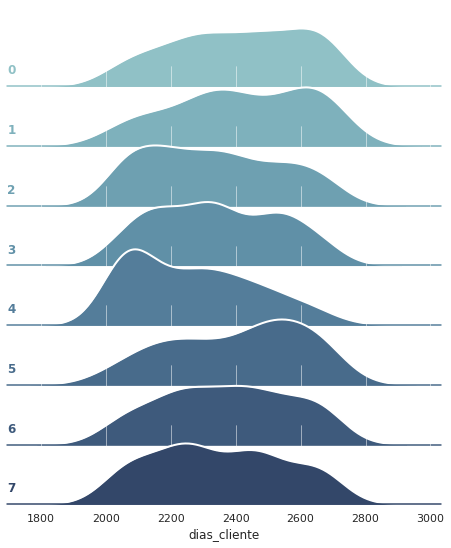


---- education_n -------------------------------------------------------


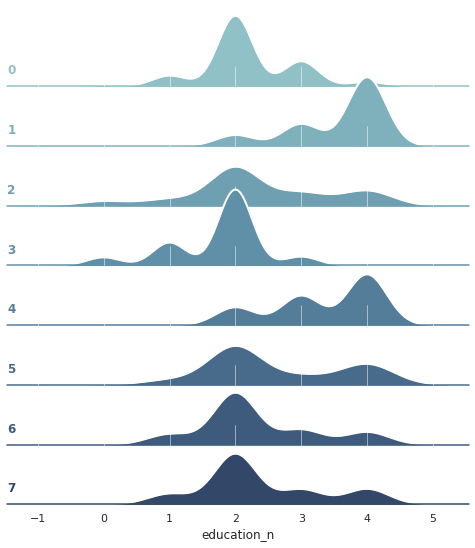


---- parceiro -------------------------------------------------------


Dataset has 0 variance; skipping density estimate.
Dataset has 0 variance; skipping density estimate.
Dataset has 0 variance; skipping density estimate.
Dataset has 0 variance; skipping density estimate.
Dataset has 0 variance; skipping density estimate.
Dataset has 0 variance; skipping density estimate.
Dataset has 0 variance; skipping density estimate.
Dataset has 0 variance; skipping density estimate.
Dataset has 0 variance; skipping density estimate.
Dataset has 0 variance; skipping density estimate.
Dataset has 0 variance; skipping density estimate.
Dataset has 0 variance; skipping density estimate.


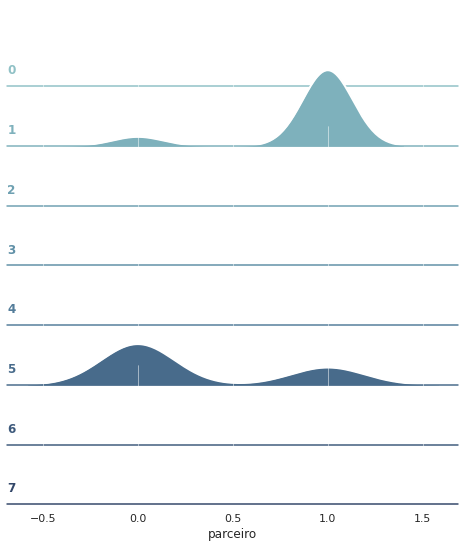


---- pessoas_casa -------------------------------------------------------


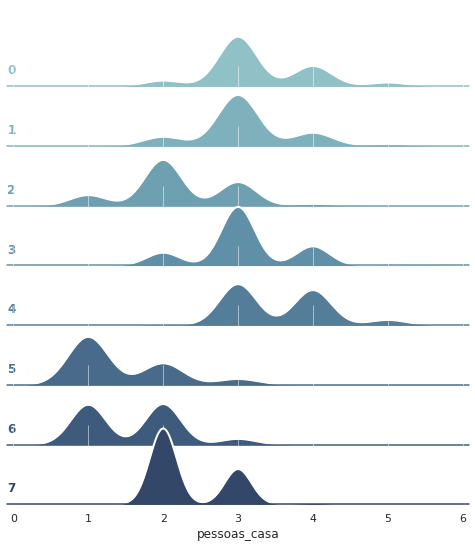


---- renda_per_capta -------------------------------------------------------


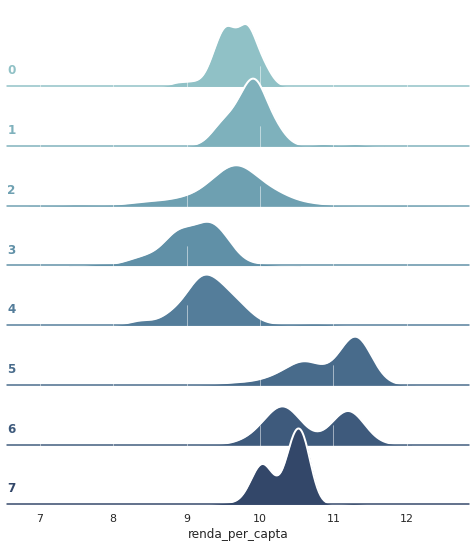


---- compra_total_ano -------------------------------------------------------


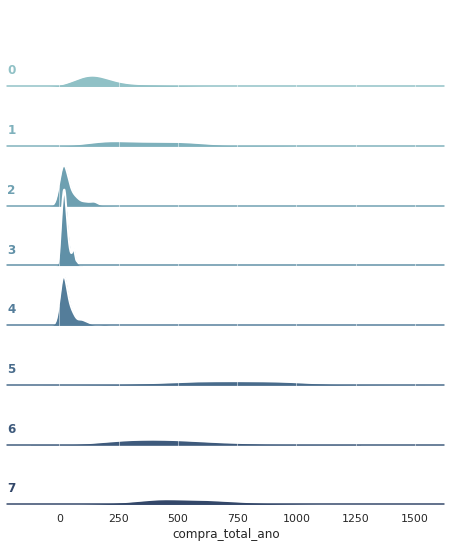


---- porcentagem_compras_gold -------------------------------------------------------


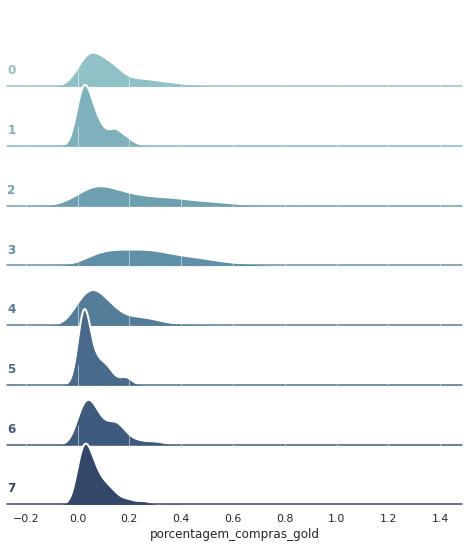


---- gasto_renda -------------------------------------------------------


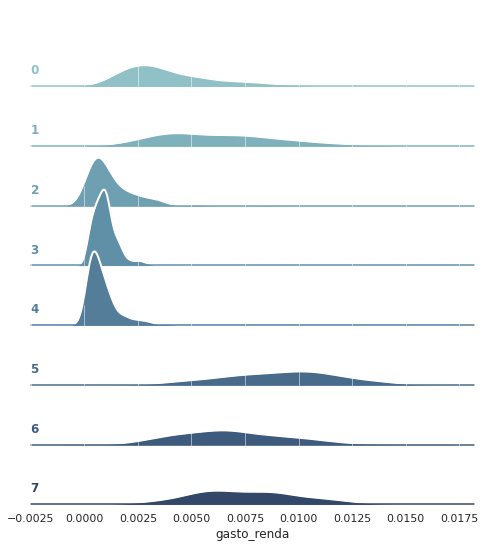


---- total_purchases -------------------------------------------------------


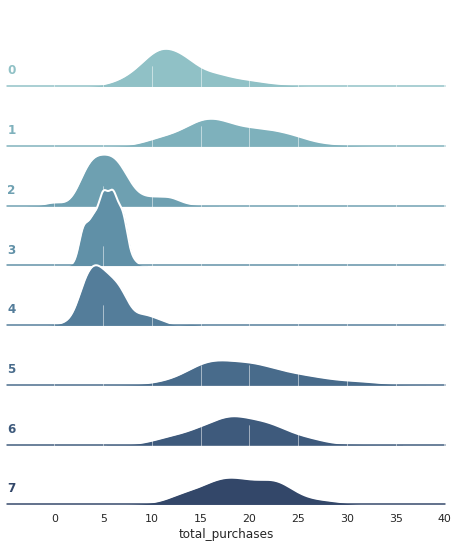


---- disc_purchases -------------------------------------------------------


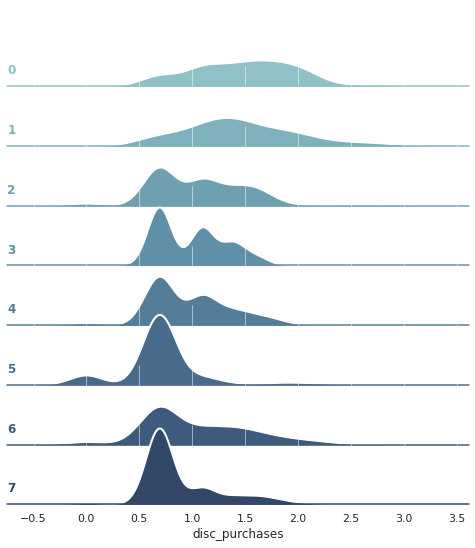


---- num_compras_ano -------------------------------------------------------


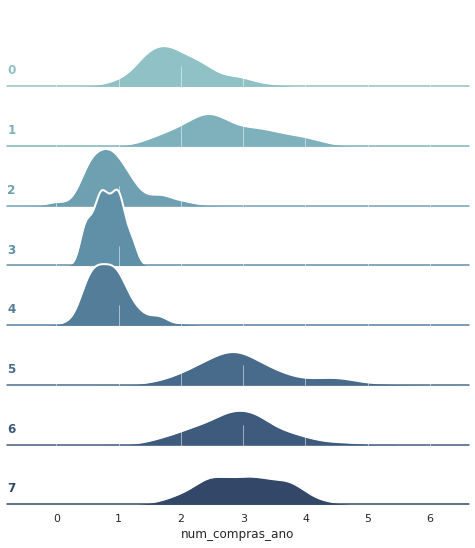


---- percent_disc_compra -------------------------------------------------------


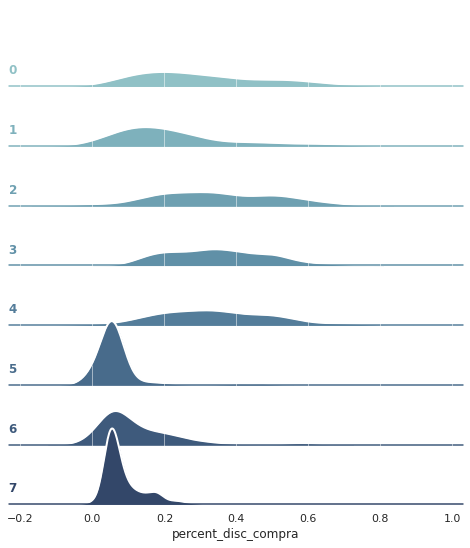


---- ticket_medio -------------------------------------------------------


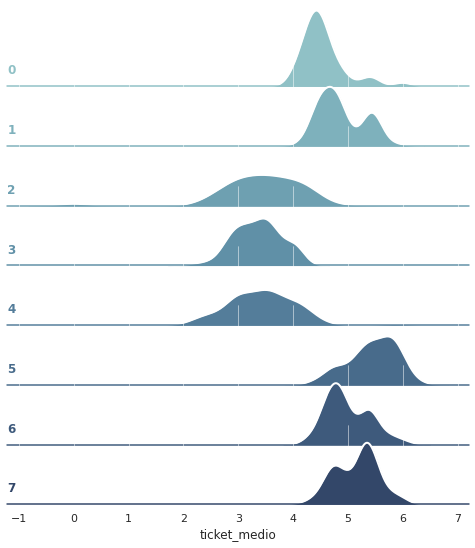


---- conversao_site -------------------------------------------------------


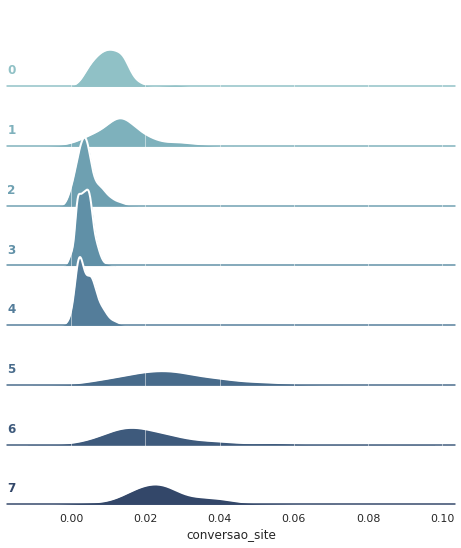


---- cupons_aceitados -------------------------------------------------------


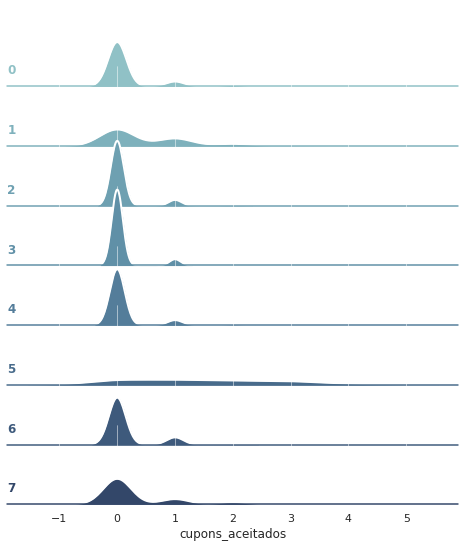

CENTROIDS:



ValueError: could not convert string to float: 'Graduation'

In [36]:
md.plot_train_info(Xtrain_p.sample(1_000))